In [1]:
# @title
import unittest
from IPython.display import Markdown, display
import numpy as np

def printmd(string):
    display(Markdown(string))

V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

pol_opt = np.hstack((np.ones(11), 2, 0))

V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:13][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

def get_long_path(V):
    return np.array(np.hstack((V[0:13][0], V[1][0], V[1][11], V[2][0], V[2][11], V[3][0], V[3][11])))

def get_optimal_path(policy):
    return np.array(np.hstack((policy[2][:], policy[3][0])))

class Tests(unittest.TestCase):

    def td_prediction_check(self, V):
        to_check = get_long_path(V)
        soln = get_long_path(V_true)
        np.testing.assert_array_almost_equal(soln, to_check)

    def td_control_check(self, policy):
        to_check = get_optimal_path(policy)
        np.testing.assert_equal(pol_opt, to_check)

check = Tests()

def run_check(check_name, func):
    try:
        getattr(check, check_name)(func)
    except check.failureException as e:
        printmd('**<span style="color: red;">PLEASE TRY AGAIN</span>**')
        return
    printmd('**<span style="color: green;">PASSED</span>**')

In [2]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

def plot_values(V):
	# reshape the state-value function
	V = np.reshape(V, (4,12))
	# plot the state-value function
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
	    ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title('State-Value Function')
	plt.show()

In [3]:
# @title
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.3 MB/s eta 0:00:00


# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [4]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [5]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [6]:
print(env.unwrapped.nA)
print(env.action_space)
print(env.observation_space)

4
Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

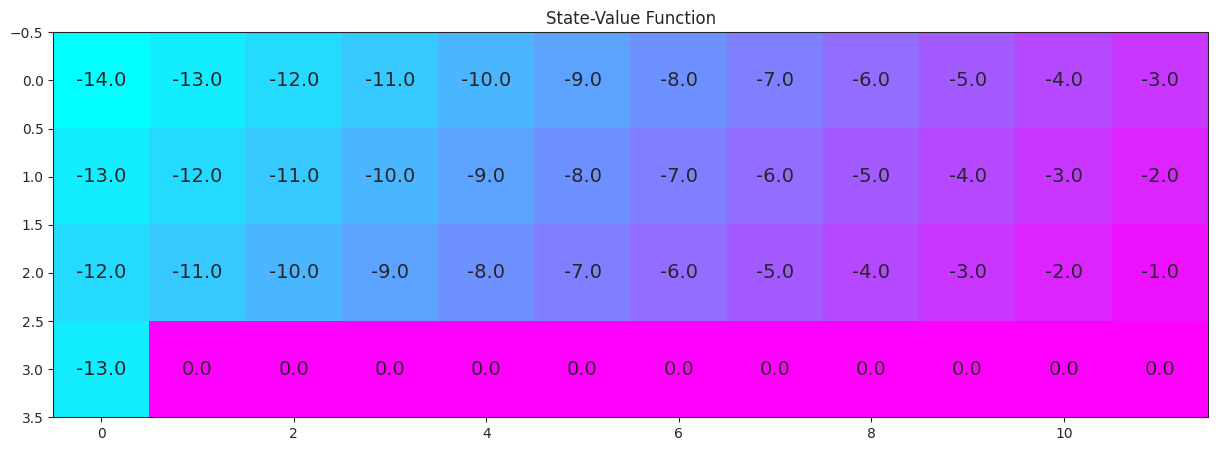

In [7]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

## Explore environment

In [8]:
for i_episode in range(1):
    state = env.reset()
    print(f'initial state : {state}')
    episode = []
    while True:
        action = env.action_space.sample()
        state, reward, done, info, prob = env.step(action)
        episode.append((state, action, reward))
        if done:
            print('End game! Episode: ', episode)
            break

initial state : (36, {'prob': 1})
End game! Episode:  [(36, 3, -1), (36, 2, -1), (36, 1, -100), (36, 2, -1), (36, 3, -1), (24, 0, -1), (12, 0, -1), (13, 1, -1), (12, 3, -1), (13, 1, -1), (12, 3, -1), (24, 2, -1), (25, 1, -1), (24, 3, -1), (12, 0, -1), (13, 1, -1), (12, 3, -1), (24, 2, -1), (12, 0, -1), (13, 1, -1), (12, 3, -1), (12, 3, -1), (24, 2, -1), (24, 3, -1), (25, 1, -1), (24, 3, -1), (25, 1, -1), (36, 2, -100), (36, 2, -1), (36, 3, -1), (36, 1, -100), (36, 2, -1), (36, 2, -1), (36, 3, -1), (36, 3, -1), (24, 0, -1), (12, 0, -1), (24, 2, -1), (12, 0, -1), (0, 0, -1), (0, 3, -1), (1, 1, -1), (0, 3, -1), (0, 0, -1), (1, 1, -1), (13, 2, -1), (12, 3, -1), (12, 3, -1), (0, 0, -1), (1, 1, -1), (13, 2, -1), (12, 3, -1), (24, 2, -1), (36, 2, -1), (36, 3, -1), (24, 0, -1), (12, 0, -1), (0, 0, -1), (12, 2, -1), (12, 3, -1), (0, 0, -1), (12, 2, -1), (24, 2, -1), (24, 3, -1), (24, 3, -1), (24, 3, -1), (12, 0, -1), (13, 1, -1), (25, 2, -1), (24, 3, -1), (25, 1, -1), (26, 1, -1), (25, 3, -1), 

### Episode Generation

You don't need to append episodes for SARSA, this is the most crucial difference from MD control.

In [9]:
def get_prob(Q_cur, epsilon):
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    best_action = np.argmax(Q_cur)
    output[best_action] = 1 - epsilon + epsilon / A_s
    return output

def generate_episode_greedy_policy(bj_env, Q, epsilon):
    episode = []
    state = bj_env.reset()
    while True:
        # if first visit, don't need to adapt greedy policies
        if state in Q:
          probs = get_prob(Q[state], epsilon)
          action = np.random.choice(np.arange(bj_env.nA), p=probs)
        else:
          action = bj_env.action_space.sample()

        next_state, reward, done, info, prob = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

## SARSA Implementation

In [12]:
def get_prob(Q_cur, epsilon):
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    output[np.argmax(Q_cur)] += (1 - epsilon)
    return output

def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.unwrapped.nA
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function
        s, _ = env.reset()
        score = 0.0
        epsilon = 1.0 / i_episode

        while True:
            a = np.random.choice(np.arange(nA), p=get_prob(Q[s], epsilon))
            s_t_1, r, done, info, _ = env.step(a)
            a_t_1 = np.random.choice(np.arange(nA), p=get_prob(Q[s_t_1], epsilon))
            score += r

            if done:
                Q[s][a] = Q[s][a] + alpha*(r + 0 - Q[s][a])
                tmp_scores.append(score) # append score
                break
            else:
                Q[s][a] = Q[s][a] + alpha*(r + gamma*Q[s_t_1][a_t_1] - Q[s][a])

            s = s_t_1

        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

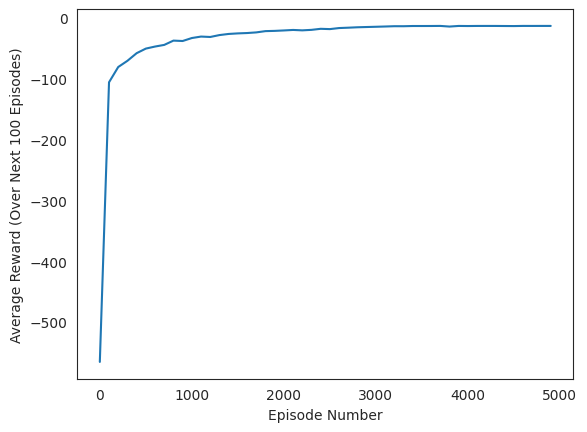

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  0  1  1  1  2  2  1  1  2  1]
 [ 0  1  1  1  2  1  2  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


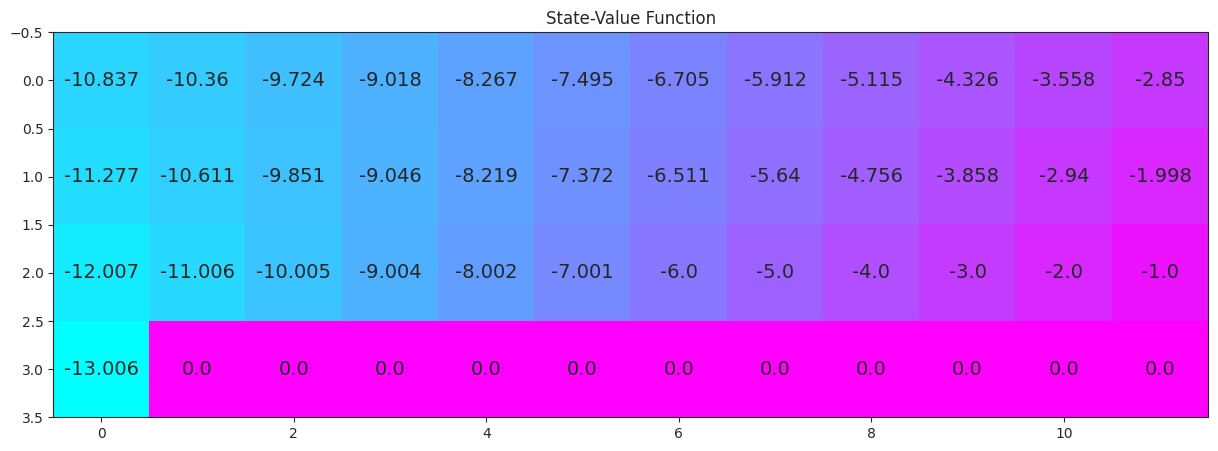

In [26]:
# @title
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [27]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.unwrapped.nA
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function
        s, _ = env.reset()
        score = 0.0
        epsilon = 1.0 / i_episode

        while True:
            # Only one step can accomplish SARSA Max
            a = np.random.choice(np.arange(nA), p=get_prob(Q[s], epsilon))
            s_t_1, r, done, info, _ = env.step(a)
            score += r

            if done:
                Q[s][a] = Q[s][a] + alpha*(r + 0 - Q[s][a])
                tmp_scores.append(score) # append score
                break
            else:
                Q[s][a] = Q[s][a] + alpha*(r + gamma*np.max(Q[s_t_1]) - Q[s][a])

            s = s_t_1

        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

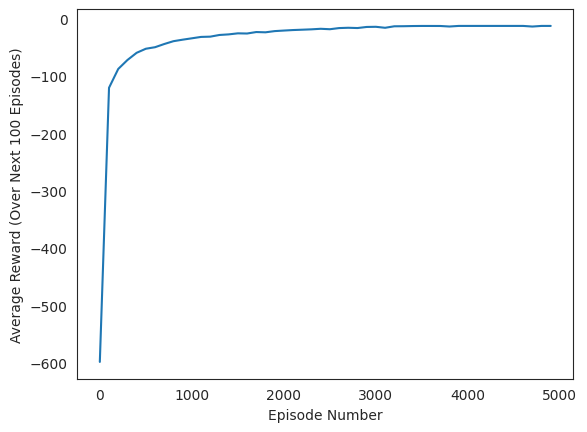

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  3  3  1  1  2  1  1  1  1  2]
 [ 2  3  0  1  2  0  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


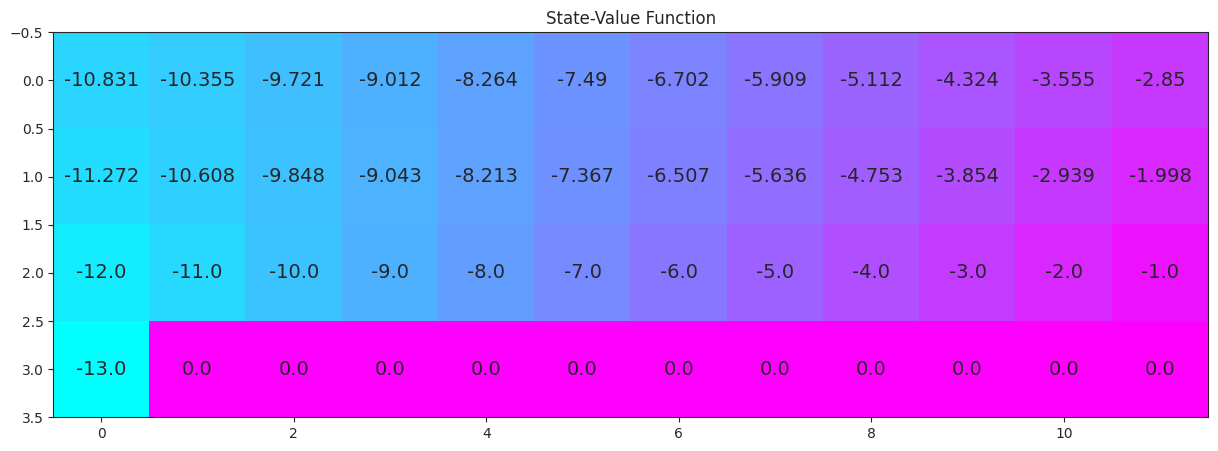

In [28]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

 ## *Caution!!*

 Expected Sarsa requires fixed small epsilon for greedy policy.

In [42]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.unwrapped.nA
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function
        s, _ = env.reset()
        score = 0.0
        # epsilon = 1.0 / i_episode
        epsilon = 0.005

        while True:
            a = np.random.choice(np.arange(nA), p=get_prob(Q[s], epsilon))
            s_t_1, r, done, info, _ = env.step(a)
            score += r
            a_prob = get_prob(Q[s_t_1], epsilon)


            if done:
                Q[s][a] = Q[s][a] + alpha*(r + 0 - Q[s][a])
                tmp_scores.append(score) # append score
                break
            else:
                Q[s][a] = Q[s][a] + alpha*(r + gamma * np.sum(a_prob * Q[s_t_1]) - Q[s][a])

            s = s_t_1

        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

### Test code with small iter

Episode 200/200

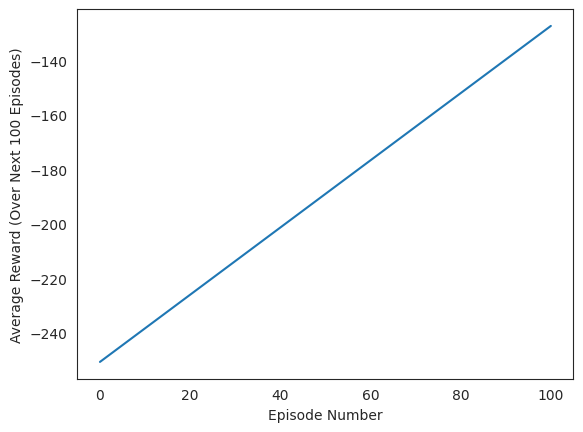

Best Average Reward over 100 Episodes:  -127.45


defaultdict(<function __main__.expected_sarsa.<locals>.<lambda>()>,
            {36: array([-3.99240237, -4.00000035, -3.99243911, -3.99257314]),
             24: array([-3.59909621, -3.60483224, -3.6094377 , -3.6000681 ]),
             12: array([-3.39909528, -3.39753847, -3.40688185, -3.39990871]),
             0: array([-3.32001944, -3.32017581, -3.3163713 , -3.32004791]),
             1: array([-3.22997336, -3.22863869, -3.23420711, -3.23461719]),
             2: array([-3.10005382, -3.10186417, -3.09942963, -3.09705036]),
             3: array([-2.94999309, -2.94294644, -2.94944663, -2.94914073]),
             4: array([-2.77005586, -2.77379086, -2.77163561, -2.78019097]),
             5: array([-2.5900025 , -2.58959964, -2.59632821, -2.59321763]),
             6: array([-2.4000162 , -2.40003308, -2.39459812, -2.40447108]),
             7: array([-2.19999765, -2.20467199, -2.20161787, -2.20282227]),
             8: array([-2.0000079 , -2.00000217, -1.99502201, -1.99750079]),
     

In [43]:
env = gym.make('CliffWalking-v0')
Q_sarsamax = expected_sarsa(env, 200, .01)

Episode 5000/5000

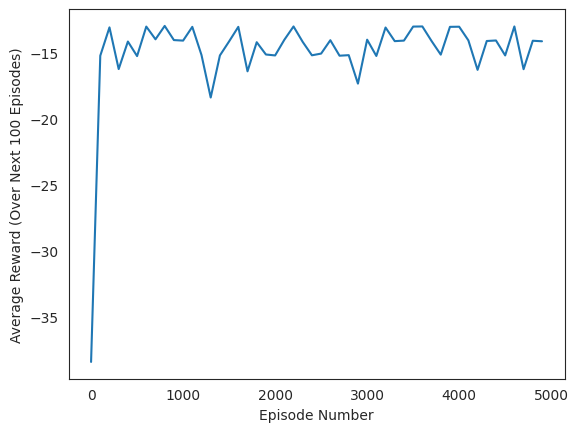

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  3  1  3  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


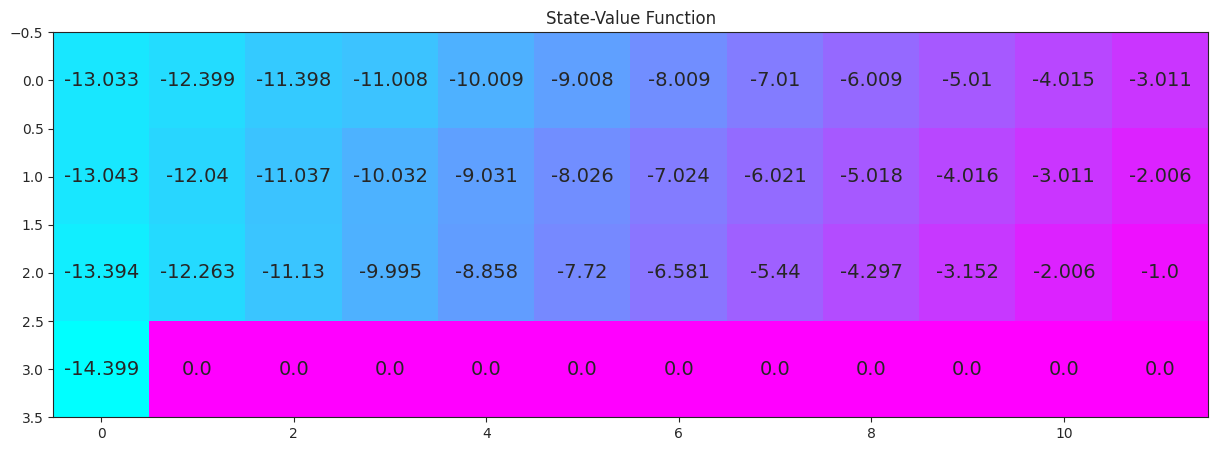

In [44]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])